# Navier-Stokes with a pivot-fixed falling flat plate 
## Using `Whirl` and `Dyn3d`

In [1]:
include(joinpath(Pkg.dir("Whirl"), "src/Whirl.jl"))
using Whirl

include(Pkg.dir("Dyn3d")*"/src/Dyn3d.jl")
using Dyn3d

In [2]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

## <span style="color:blue"> Set up rigid body with Dyn3d

In [3]:
include(Pkg.dir("Dyn3d")*"/src/config_files/2dFall.jl")

Config info set up.


#### Build joint-body chain

In [4]:
# build joint-body chain
bodys, joints, system = BuildChain(config_bodys, config_joints, config_system)
bd = BodyDyn(bodys, joints, system)

#### Initialize rigid body system state

In [5]:
# init system
bd, soln = InitSystem!(bd)

# init soln structure
solns = (Soln)[]
push!(solns, soln)

# init VertsHistory struct
vs = []
push!(vs, VertsHistory(system.nbody, bd.bs));

This is a 1 body-joint system.
System is fixed in space


#### Set up HERKBody object

In [6]:
herkbody = Dyn3d.HERKBody(system.num_params,HERKFuncM, HERKFuncGT, HERKFuncG,
                (HERKFuncf,HERKFuncgti), (UpdatePosition!,UpdateVelocity!))

Order-3 HERK integrator.


#### Genrate body grid points and get linear velocity on in

In [7]:
# generate body points and fit it into 2d, which each items choose [1,3] for 2d cases in [x,y]
bgs = GenerateBodyGrid(bd; np=201)
bgs = CutOut2d(bd,bgs)
bgs = AcquireBodyGridKinematics(bd,bgs)

coord = hcat(bgs[1].q_i...)'[:,[1,2]]
motion = hcat(bgs[1].v_i...)'[:,[1,2]]
for i = 2:length(bgs)
    coord = [coord[1:end-1,:]; hcat(bgs[i].q_i...)'[:,[1,2]]]
    motion = [motion[1:end-1,:]; hcat(bgs[i].v_i...)'[:,[1,2]]]
end

#### Plot body only

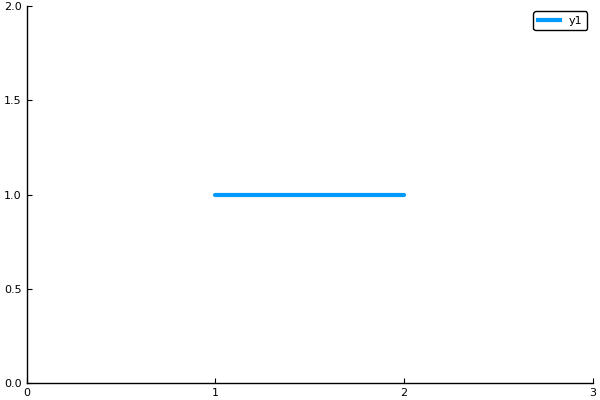

In [8]:
v = isdefined(:plot_dir) ? plot_dir : system.ndim==2 ? (1,2) : (1,2,3)
p = plot(vs[1][1,:,1],vs[1][1,:,2], linewidth=3, aspect_ratio=:equal)        
plot!(xlims=(0,3), ylims=(0,2))

## <span style="color:blue"> Set up fluid solver with Whirl </span>

Set the flow parameters

In [9]:
Re = 200; # Reynolds number
U = 1.0; # Free stream velocity
U∞ = (U,0.0);

Set the domain size and time step size

In [10]:
nx = 152; ny = 102;
Ly = 2.0;
Δx = Ly/(ny-2);
Δt = min(0.5*Δx,0.5*Δx^2*Re)
w₀ = Nodes(Dual,(nx,ny));
xg, yg = coordinates(w₀,dx=Δx)

(-0.01:0.02:3.0100000000000002, -0.01:0.02:2.0100000000000002)

#### Set up the Navier-Stokes  problem type

In [11]:
X̃ = VectorData(coord)
sys = Systems.NavierStokes((nx,ny),Re,Δx,Δt,U∞ = U∞, X̃ = X̃, isstore = true, isstatic = false)

Navier-Stokes system on a grid of size 152 x 102

#### Set up initial conditions

In [12]:
t = 0.0
w₀ .= 0.0
tf = 5*Δt
T = Δt:Δt:tf
fx = Float64[]
fy = Float64[]
thist = []
uhist = []
tsample = 0.02;

## <span style="color:blue"> Preparation for Time Marching </span>

#### Constants for coupling

In [14]:
tol = 5e-4
soln.dt = Δt
ω = (config_bodys[1].ρ)/(1.0+config_bodys[1].ρ)

0.5

#### Helper function to convert VectorData type

In [15]:
import Base: +,*
function (+)(a::VectorData, b::VectorData)
    c = VectorData(a)
    c.u .= a.u .+ b.u
    c.v .= a.v .+ b.v
    return c
end

function (*)(ω::T, a::VectorData) where T<: Real
    c = VectorData(a)
    c.u .= ω.*a.u
    c.v .= ω.*a.v
    return c
end

function (*)(a::VectorData,ω::T) where T<: Real
    c = VectorData(a)
    c.u .= ω.*a.u
    c.v .= ω.*a.v
    return c
end

* (generic function with 287 methods)

#### Create Body solver object of type HerkBody

In [16]:
# construct body solver
herk = HERKBody(system.num_params,HERKFuncM, HERKFuncGT, HERKFuncG,
            (HERKFuncf,HERKFuncgti),
            (UpdatePosition!,UpdateVelocity!))

Order-3 HERK integrator.


#### Create Fluid solver object of type IFHERK

In [17]:
u = (w₀,[coord motion][:])
f = (VectorData(X̃),Vector{Float64}())

# number of constraints (4*body points)
nc = length(u[2])

# construct fluid solver with uniform constant free stream
ifherk = Whirl.IFHERK(u,f,sys.Δt,
                ((t,u) -> Systems.plan_intfact(t,u,sys),
                 (t,u) -> eye(nc)),
                (u,t) -> Whirl.plan_constraints(u,t,sys),
                ((u,t) -> Whirl.r₁(u,t,sys),
                 (u,t) -> Whirl.r₂(u,t,sys)),
                tol=1e-3,rk=Whirl.TimeMarching.RK31,
                isstored=true,isstaticconstraints=false)

Order-3 IF-HERK integrator with
   State of type Tuple{Whirl.Fields.Nodes{Whirl.Fields.Dual,152,102},Array{Float64,1}}
   Force of type Tuple{Whirl.Fields.VectorData{51},Array{Float64,1}}
   Time step size 0.01


## <span style="color:blue"> Time Marching! </span>

In [22]:
@time for t in T

    cnt = 1
    fᵢ = -1*f[1]*Δx^2

    # record body info
    soln_buffer = deepcopy(soln)
    bd_buffer = deepcopy(bd)
    bgs_buffer = deepcopy(bgs)

    # record fluid info
    u_buffer = deepcopy(u)
    t_buffer = t

    while true

        # get body state of the last timestep
        soln = deepcopy(soln_buffer)
        bd = deepcopy(bd_buffer)
        bgs = deepcopy(bgs_buffer)

        # integrate body force for body solver
        for i = 1:bgs[1].np
            bgs[1].f_ex3d[i][1] = fᵢ.u[i]
            bgs[1].f_ex3d[i][3] = fᵢ.v[i]
        end
        bgs = IntegrateBodyGridDynamics(bd,bgs)
        f_exi = zeros(bd.sys.nbody,6)
        for i = 1:bd.sys.nbody
            f_exi[i,:] = bgs[i].f_ex6d
        end

        # advance body solver for one step
        soln, bd = herkbody(soln, bd; _isfixedstep=true, f_exi=f_exi);

        # acquire vel and coord of body points for fluid computation
        bgs = AcquireBodyGridKinematics(bd,bgs)
        coord = hcat(bgs[1].q_i...)'[:,[1,2]]
        motion = hcat(bgs[1].v_i...)'[:,[1,2]]
        for i = 2:length(bgs)
            coord = [coord[1:end-1,:]; hcat(bgs[i].q_i...)'[:,[1,2]]]
            motion = [motion[1:end-1,:]; hcat(bgs[i].v_i...)'[:,[1,2]]]
        end

        # get fluid state of the last timestep
        u = deepcopy(u_buffer)
        t = t_buffer

        # advance fluid solver for one step
        u = (u[1],[coord motion][:])
        t, u, f = ifherk(t,u)

        # check if converge
        ϵ = norm(-1*f[1]*Δx^2 - fᵢ)
        if ϵ < tol break end

#         println("proposed fy:", sum(fᵢ.v))
#         println("corrected fy:", sum(-1*f[1].v)*Δx^2)

        # if not converge, use relaxation
        fᵢ = (1-ω)*fᵢ + ω*(-1*f[1])*Δx^2

#         println("relaxation fy:", sum(fᵢ.v),"\n")

        # loop count
#         println("count ",cnt,", ϵ = ",ϵ,"\n");
        cnt += 1
    end

    # converged for this timestep
    print("time = ", t, " converged through ", cnt, " iterations\n")
    
    # record body info
    push!(solns, soln)
    push!(vs, VertsHistory(system.nbody, bd.bs))

    # record fluid info
    push!(thist,t)
    push!(fx,sum(fᵢ.u))
    push!(fy,sum(fᵢ.v))
    push!(uhist,deepcopy(u))
    
end

println("solution completed through time t = ",t)

1 ru= [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0

 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0

0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0

0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0

 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 

LoadError: [91mtype Array has no field data[39m

#### Plot first and last time field

In [25]:
plot(xg,yg,uhist[1][1],levels=linspace(-0.05,0.05,80))
plot!(bd.bs[1].verts_i[2:3,1], bd.bs[1].verts_i[2:3,2],linewidth=2,linecolor="grey")

LoadError: [91mBoundsError: attempt to access 0-element Array{Any,1} at index [1][39m

In [26]:
plot(xg,yg,uhist[end][1],levels=linspace(-0.05,0.05,80))
plot!(bd.bs[1].verts_i[2:3,1], bd.bs[1].verts_i[2:3,2],linewidth=2,linecolor="grey")

LoadError: [91mBoundsError: attempt to access 0-element Array{Any,1} at index [0][39m

#### Gif!

In [27]:
bd.bs[1].verts_i[2:3,1:2]

2×2 Array{Float64,2}:
 1.0  1.0     
 2.0  0.999999

In [28]:
@get bd (bs, js, sys)

# get verts info based on this regular grid solution
vshist = []
for i = 1:length(solns)
    bs, js, sys = UpdatePosition!(bs, js, sys, solns[i].qJ)
    push!(vshist, VertsHistory(sys.nbody, bs))
end

In [29]:
@gif for i = 1:length(uhist)
    plot(xg,yg,uhist[i],levels=linspace(-0.05,0.05,80))
    plot!(vshist[i][1,2:3,1], vshist[51][1,2:3,2],linewidth=2,linecolor="grey")
    plot!(xlims=(0.8,2.2), ylims=(0.7,1.3))
end

LoadError: [91mfailed process: Process(`ffmpeg -v 0 -i /tmp/tmp8ADPhA/%06d.png -vf palettegen=stats_mode=diff -y /tmp/tmp8ADPhA/palette.bmp`, ProcessExited(1)) [1][39m

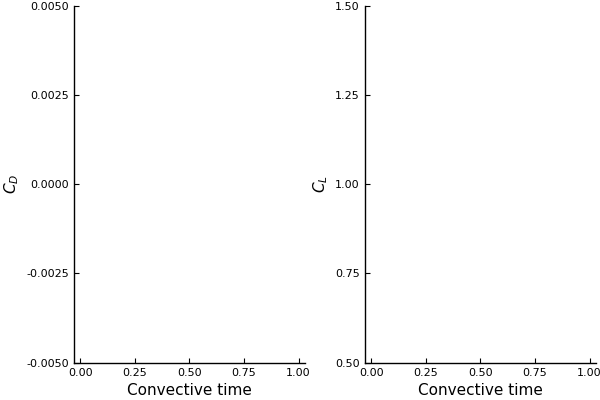

In [30]:
px = plot(thist,2*fx,ylim=(-0.005,0.005),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
py = plot(thist,2*fy,ylim=(0.5,1.5),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot(px,py)